In [1]:
# comment out when running on google colab
# !pip install -q einops datasets loguru


## Dataset

In [2]:
import numpy as np
import torch
from datasets import load_dataset
from datasets.arrow_dataset import Dataset as D
from loguru import logger
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from typing import List, Dict, Set


In [3]:

class SkipgramDataset(Dataset):
    def __init__(self,
                 n_instances: int,
                 window_size: int,
                 min_word_freq: int,
                 base_dataset_name: str = "multi_news") -> None:
        
        # https://huggingface.co/datasets/multi_news
        self.base_dataset_name = base_dataset_name
        # how many instances from the dataset should be used
        # sure you can use the whole dataset but
        # that'll mean a lot of data and longer training time
        # if n_instances = -1, the whole dataset will be used
        self.n_instances = n_instances
        self.window_size = window_size
        self.min_word_freq = min_word_freq
        
        
        # load dataset
        logger.info(f"Loading dataset :: {self.base_dataset_name}")
        
        if self.n_instances == -1:
            logger.warning("Using the whole dataset!")
            self.base_dataset = load_dataset(
                self.base_dataset_name)["train"][:]["document"]
        else:
            self.base_dataset = load_dataset(
                self.base_dataset_name)["train"][:self.n_instances]["document"]
        
        logger.info("Preprocessing ....")
        self.word_to_idx, self.word_freqs, self.vocabulary = self.__preprocess()
        
        self.vocab_size = len(self.vocabulary)
        logger.info(f"Vocabulary size :: {len(self.vocabulary)}")
        
        
        logger.info("Subsampling ....")
        self.subsampled_vocab = self.__subsample()
        self.sub_vocab_size = len(self.subsampled_vocab)
        logger.info(f"Subsampled Vocabulary Size :: {self.sub_vocab_size}")
        
        # create a reverse lookup table
        # int to word
        logger.info("Generating idx_to_word ....")
        self.idx_to_word = {self.word_to_idx.get(word): word for word in self.vocabulary}
        
        logger.info("Storing unigram probabilities ....")
        self.total_words = sum(self.word_freqs.values())
        
        
        # populate
        logger.info("Creating target context pairs ....")
        self.pairs = self.__create_target_context_pairs()
        logger.success(f"Done! Created {len(self.pairs)} instances.")
        
        
    # utils
    def __clean_and_tokenise(self, text: str) -> List[str]:
        # lowercase
        doc = text.lower()
        # replace space + newline with empty str
        doc = doc.replace(" \n", "")
        # split
        doc = doc.split()
        return doc
    
    def __preprocess(self) -> tuple:
        # word to idx mapping
        word_to_idx = dict()

        # frequencies
        word_freqs = dict()


        for _, ds in tqdm(enumerate(self.base_dataset), total=len(self.base_dataset), desc="update_freq"):
            doc = self.__clean_and_tokenise(ds)

            # update freq
            for word in doc:
                if not word in word_freqs.keys():
                    word_freqs[word] = 1
                else:
                    word_freqs[word] += 1


        # filter words which have a frequency of less than min_freq
        # as the final words list / vocabulary
        vocabulary = [w for w in word_freqs.keys() if word_freqs[w] >= self.min_word_freq]
            
        # sort vocabulary in the descending order of frequency
        vocabulary = sorted(vocabulary, key=word_freqs.get, reverse=True) # type: ignore
        
        # populate word_to_idx
        for idx, word in tqdm(enumerate(vocabulary), total=len(vocabulary), 
                          desc="word_to_idx"):
            word_to_idx[word] = idx
        

        return word_to_idx, word_freqs, vocabulary
    
    # select a subsampled list to be used as vocabulary from the main vocab list
    def __subsample(self) -> List[str]:
        T = 1e-5 # follwing the original threshold from the paper
        
        # probability for a single word using its frequency
        def subsample_probability(frequency):
            return 1 - np.sqrt(T / frequency)
        
        # freq(word) / vocab_size : what is the representation of the word in the total corpus
        # more frequent words such as the, to don't really contribute much to the meaning of another vector
        # and hence can be dropped for the sake of learning good word vectors
        # https://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
        scaled_frequencies = { word: self.word_freqs[word] / self.vocab_size for word in self.vocabulary } 
        
        
        # get the probability of a word to drop
        drop_probability = { word: subsample_probability(scaled_frequencies[word]) for word in self.vocabulary}
        
        # if probability of being dropped is drop_probability then for remaining, 1 - drop_probability
        subsampled_vocab = [word for word in self.vocabulary if np.random.rand() < (1 - drop_probability[word])]
        
        # update original vocabulary with the subsampled one
        return subsampled_vocab
    
    
    # the target word index is the index of the word in the list
    def __get_context_words(self, tokens: List[str], target_word_index: int) -> List[str]:
        # index range to look for
        # we look among window_size words left and right of the targer word in a sentence
        index_range = np.random.randint(1, self.window_size)
        
        # we look through all the tokens in a sentence and pick context words
        # excluding the target word
        
        start = max(0, target_word_index - index_range)
        finish = min(target_word_index + index_range, len(tokens) - 1)
        
        context_words = tokens[start: target_word_index] + tokens[target_word_index + 1 : finish + 1]
        # discard words which failed to meet min freq (in preprocessing)
        # and are not part of the vocab
        context_words = [cw for cw in context_words if self.word_to_idx.get(cw) is not None]
        
        return context_words
    
    def __create_target_context_pairs(self) -> Dict[str, Set]:
        pairs = dict()
        
        for _, sentence in tqdm(enumerate(self.base_dataset), 
                                  desc="create_pairs",
                                  total=len(self.base_dataset)):
            
            tokens = self.__clean_and_tokenise(sentence)
            for index, token in enumerate(tokens):
                context_words = self.__get_context_words(tokens, index)
                
                if token not in pairs.keys():
                    pairs[token] = set(context_words)
                else:
                    pairs[token].update(context_words)
            
        
        return pairs
    
    
    # dataset methods
    def __len__(self) -> int:
        return self.sub_vocab_size
    
    
    
    def __getitem__(self, index: int) -> Dict:
        target_word = self.vocabulary[index]
        all_context_words = list(self.pairs[target_word])
        
        # randomly pick one
        random_idx = np.random.randint(0, len(all_context_words))
        context_word = all_context_words[random_idx]
        
        
        target = self.word_to_idx[target_word]
        context = self.word_to_idx[context_word]
        
        
        target = torch.tensor(target, dtype=torch.long)
        context = torch.tensor(context, dtype=torch.long)
        
        return {
            "target": target,
            "context": context,
        }

    # for negative sampling
    def get_noise_distribution(self) -> torch.Tensor:        
        frequencies = torch.tensor([
            self.word_freqs[word] for word in self.vocabulary])

        # sort in the descending order
        frequencies, _ = torch.sort(frequencies, dim=-1, descending=True, stable=True)
        
        # unigram_probabilities
        unigram_probabilities = frequencies / frequencies.sum(dim=-1)
        
        unigram_distribution = unigram_probabilities / unigram_probabilities.sum(dim=-1)
        noise_distribution = torch.pow(unigram_distribution, 0.75) /  torch.pow(unigram_distribution, 0.75).sum(dim=-1)
        
        return noise_distribution


In [4]:
train_set = SkipgramDataset(15000, 5, 5)


2023-10-21 07:31:37.605 | INFO     | __main__:__init__:20 - Loading dataset :: multi_news
2023-10-21 07:31:40.126 | INFO     | __main__:__init__:30 - Preprocessing ....


update_freq:   0%|          | 0/15000 [00:00<?, ?it/s]

word_to_idx:   0%|          | 0/146646 [00:00<?, ?it/s]

2023-10-21 07:31:46.113 | INFO     | __main__:__init__:34 - Vocabulary size :: 146646
2023-10-21 07:31:46.114 | INFO     | __main__:__init__:37 - Subsampling ....
2023-10-21 07:31:46.384 | INFO     | __main__:__init__:40 - Subsampled Vocabulary Size :: 47538
2023-10-21 07:31:46.385 | INFO     | __main__:__init__:44 - Generating idx_to_word ....
2023-10-21 07:31:46.410 | INFO     | __main__:__init__:47 - Storing unigram probabilities ....
2023-10-21 07:31:46.414 | INFO     | __main__:__init__:52 - Creating target context pairs ....


create_pairs:   0%|          | 0/15000 [00:00<?, ?it/s]

2023-10-21 07:33:34.489 | SUCCESS  | __main__:__init__:54 - Done! Created 721981 instances.


## Model

In [5]:
import torch.nn as nn
from einops import rearrange
from typing import Tuple


class SkipgramModel(nn.Module):
    def __init__(self, vocab_size: int, 
                 vocabulary: List[str],
                 word_to_idx: Dict, 
                 embedding_dim: int, 
                 noise_distribution: torch.Tensor) -> None:
        super().__init__()
        
        self.vocabulary = vocabulary
        self.vocab_size = vocab_size
        self.word_to_idx = word_to_idx
        
        self.embedding_dim = embedding_dim
        self.noise_distribution = noise_distribution
        
        # layers
        self.word_embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.output_embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # uniform init
        self.word_embedding.weight.data.uniform_(-1, 1)
        self.output_embedding.weight.data.uniform_(-1, 1)
        
    
    def generate_noise(self, batch_size: int, 
                       device: torch.device, 
                       n_samples: int=5) -> torch.Tensor:
        noise_word_idxs = torch.multinomial(self.noise_distribution, 
                                        num_samples=batch_size * n_samples, replacement=True)
        noise_word_idxs = noise_word_idxs.to(device)
        noise = self.output_embedding(noise_word_idxs)
        
        # reshape
        noise = rearrange(noise, "(batch samples) embed -> batch samples embed", 
                          batch=batch_size, samples=n_samples)
        
        return noise
        
    def forward(self, 
                target: torch.Tensor, 
                context: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        target_vectors = self.word_embedding(target)
        context_vectors = self.output_embedding(context)
        
        return target_vectors, context_vectors


In [6]:
model = SkipgramModel(train_set.vocab_size, train_set.vocabulary, train_set.word_to_idx,
                      300, train_set.get_noise_distribution())


## Negative Sampling Loss

In [7]:

class NegativeSamplingLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, target: torch.Tensor, context: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        # rearrange for matrix multiplication
        target = rearrange(target, "batch embed -> batch embed 1")
        context = rearrange(context, "batch embed -> batch 1 embed")
        
        
        word_embedding_loss = torch.bmm(context, target).sigmoid().log().squeeze()
        noise_loss = torch.bmm(noise.neg(), target).sigmoid().log().squeeze()
        
        
        total_loss = - word_embedding_loss.neg() - noise_loss.sum(dim=-1)
        mean_loss = total_loss.mean(dim=-1)
        
        return mean_loss


## Train setup

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, shuffle=True, pin_memory=True, batch_size=128)


In [11]:
from accelerate import Accelerator


accelerator = Accelerator()


## Train

In [12]:
from typing import Any

def train_step(
    model: SkipgramModel, batch: Any, criterion: NegativeSamplingLoss, device: Any
) -> torch.Tensor:
    model.train()

    target = batch["target"]
    context = batch["context"]

    target_vector, context_vector = model(target, context)
    noise_vector = model.generate_noise(target.size()[0], device)

    loss = criterion(target_vector, context_vector, noise_vector)

    return loss


In [15]:
import torch.optim as optim

def train_model(
    model: SkipgramModel,
    epochs: int,
    lr: float,
    train_dataloader: DataLoader,
    accelerator: Accelerator,
) -> tuple:
    optimiser = optim.AdamW(params=model.parameters(), lr=lr)
    criterion = NegativeSamplingLoss()

    model, optimiser, train_dataloader = accelerator.prepare(
        model, optimiser, train_dataloader
    )

    logger.info("Optimiser: Adam, Criterion: NegativeSamplingLoss")
    logger.info(f"Training for {epochs} epochs")

    global_losses = []
    for e in range(epochs):
        epoch_losses = []

        model.train()
        for batch in tqdm(train_dataloader):
            optimiser.zero_grad()

            loss = train_step(model, batch, criterion, accelerator.device)

            epoch_losses.append(loss.item())

            accelerator.backward(loss)
            optimiser.step()

        mean_epoch_loss = torch.tensor(epoch_losses).cpu().mean(dim=-1).item()
        logger.info(
            f"Epoch: [{e + 1}]/[{epochs}] ::: Mean Loss/Train : {mean_epoch_loss}"
        )
        global_losses.append(mean_epoch_loss)

    return model, global_losses


In [16]:
epochs = 15
lr = 0.003

trained_model, losses = train_model(
        model, epochs, lr, train_loader, accelerator
)


2023-10-21 07:34:47.522 | INFO     | __main__:train_model:17 - Optimiser: Adam, Criterion: NegativeSamplingLoss
2023-10-21 07:34:47.522 | INFO     | __main__:train_model:18 - Training for 15 epochs


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:34:55.057 | INFO     | __main__:train_model:36 - Epoch: [1]/[15] ::: Mean Loss/Train : 9.550946235656738


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:02.015 | INFO     | __main__:train_model:36 - Epoch: [2]/[15] ::: Mean Loss/Train : 9.144938468933105


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:08.876 | INFO     | __main__:train_model:36 - Epoch: [3]/[15] ::: Mean Loss/Train : 8.953551292419434


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:15.751 | INFO     | __main__:train_model:36 - Epoch: [4]/[15] ::: Mean Loss/Train : 8.542141914367676


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:22.612 | INFO     | __main__:train_model:36 - Epoch: [5]/[15] ::: Mean Loss/Train : 8.332978248596191


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:29.499 | INFO     | __main__:train_model:36 - Epoch: [6]/[15] ::: Mean Loss/Train : 8.047102928161621


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:36.401 | INFO     | __main__:train_model:36 - Epoch: [7]/[15] ::: Mean Loss/Train : 7.708799362182617


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:43.306 | INFO     | __main__:train_model:36 - Epoch: [8]/[15] ::: Mean Loss/Train : 7.424936771392822


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:50.228 | INFO     | __main__:train_model:36 - Epoch: [9]/[15] ::: Mean Loss/Train : 6.956384181976318


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:35:57.166 | INFO     | __main__:train_model:36 - Epoch: [10]/[15] ::: Mean Loss/Train : 6.409230709075928


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:36:04.062 | INFO     | __main__:train_model:36 - Epoch: [11]/[15] ::: Mean Loss/Train : 5.7193074226379395


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:36:10.934 | INFO     | __main__:train_model:36 - Epoch: [12]/[15] ::: Mean Loss/Train : 4.79596471786499


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:36:17.824 | INFO     | __main__:train_model:36 - Epoch: [13]/[15] ::: Mean Loss/Train : 3.6561086177825928


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:36:24.704 | INFO     | __main__:train_model:36 - Epoch: [14]/[15] ::: Mean Loss/Train : 2.2278339862823486


  0%|          | 0/372 [00:00<?, ?it/s]

2023-10-21 07:36:31.636 | INFO     | __main__:train_model:36 - Epoch: [15]/[15] ::: Mean Loss/Train : 0.44743064045906067


## Plot Losses

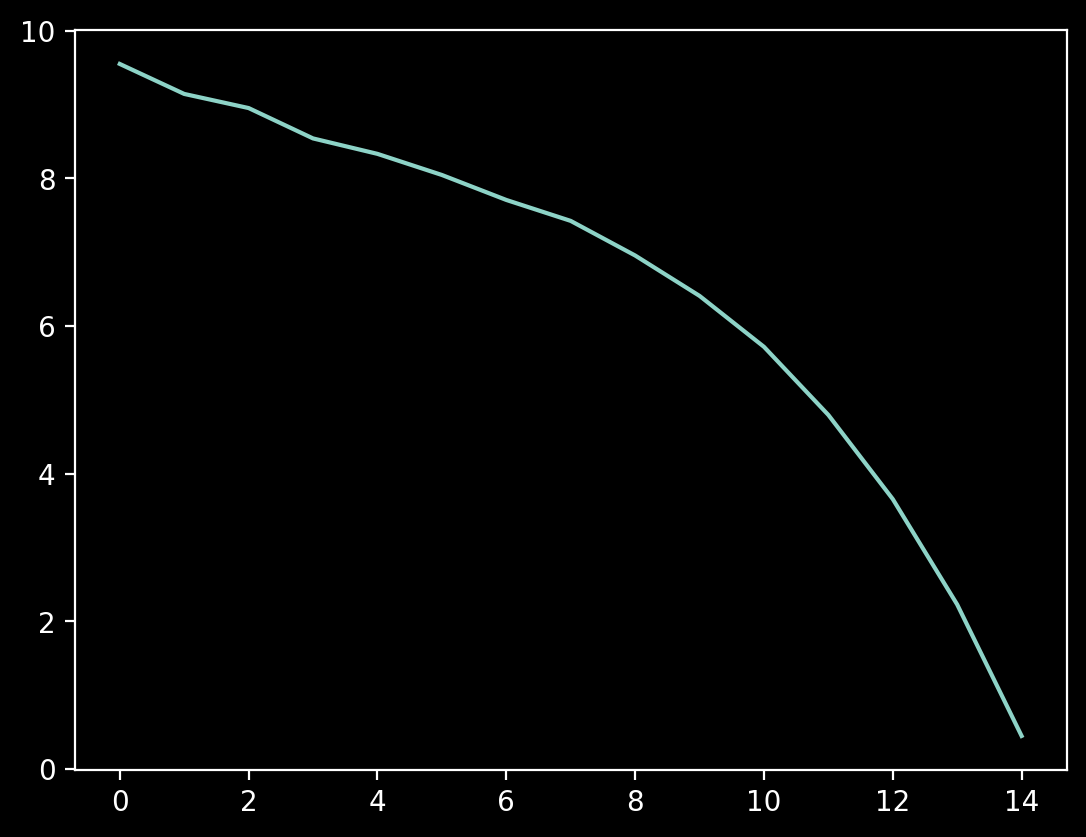

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(torch.arange(epochs).tolist(), losses)
plt.show()


## Visualise

In [18]:
from sklearn.manifold import TSNE

def visualize_n_words(n: int, model: SkipgramModel) -> None:
    embeddings_np = model.word_embedding.weight.detach().cpu().numpy()
    vocabulary = model.vocabulary

    tsne = TSNE()
    embeddings_tsne = tsne.fit_transform(embeddings_np[:n, :])

    _, _ = plt.subplots(figsize=(16, 16))
    for idx in range(n):
        plt.scatter(*embeddings_tsne[idx, :], color="steelblue")
        plt.annotate(
            vocabulary[idx],
            (embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
            alpha=0.7,
        )

    plt.show()


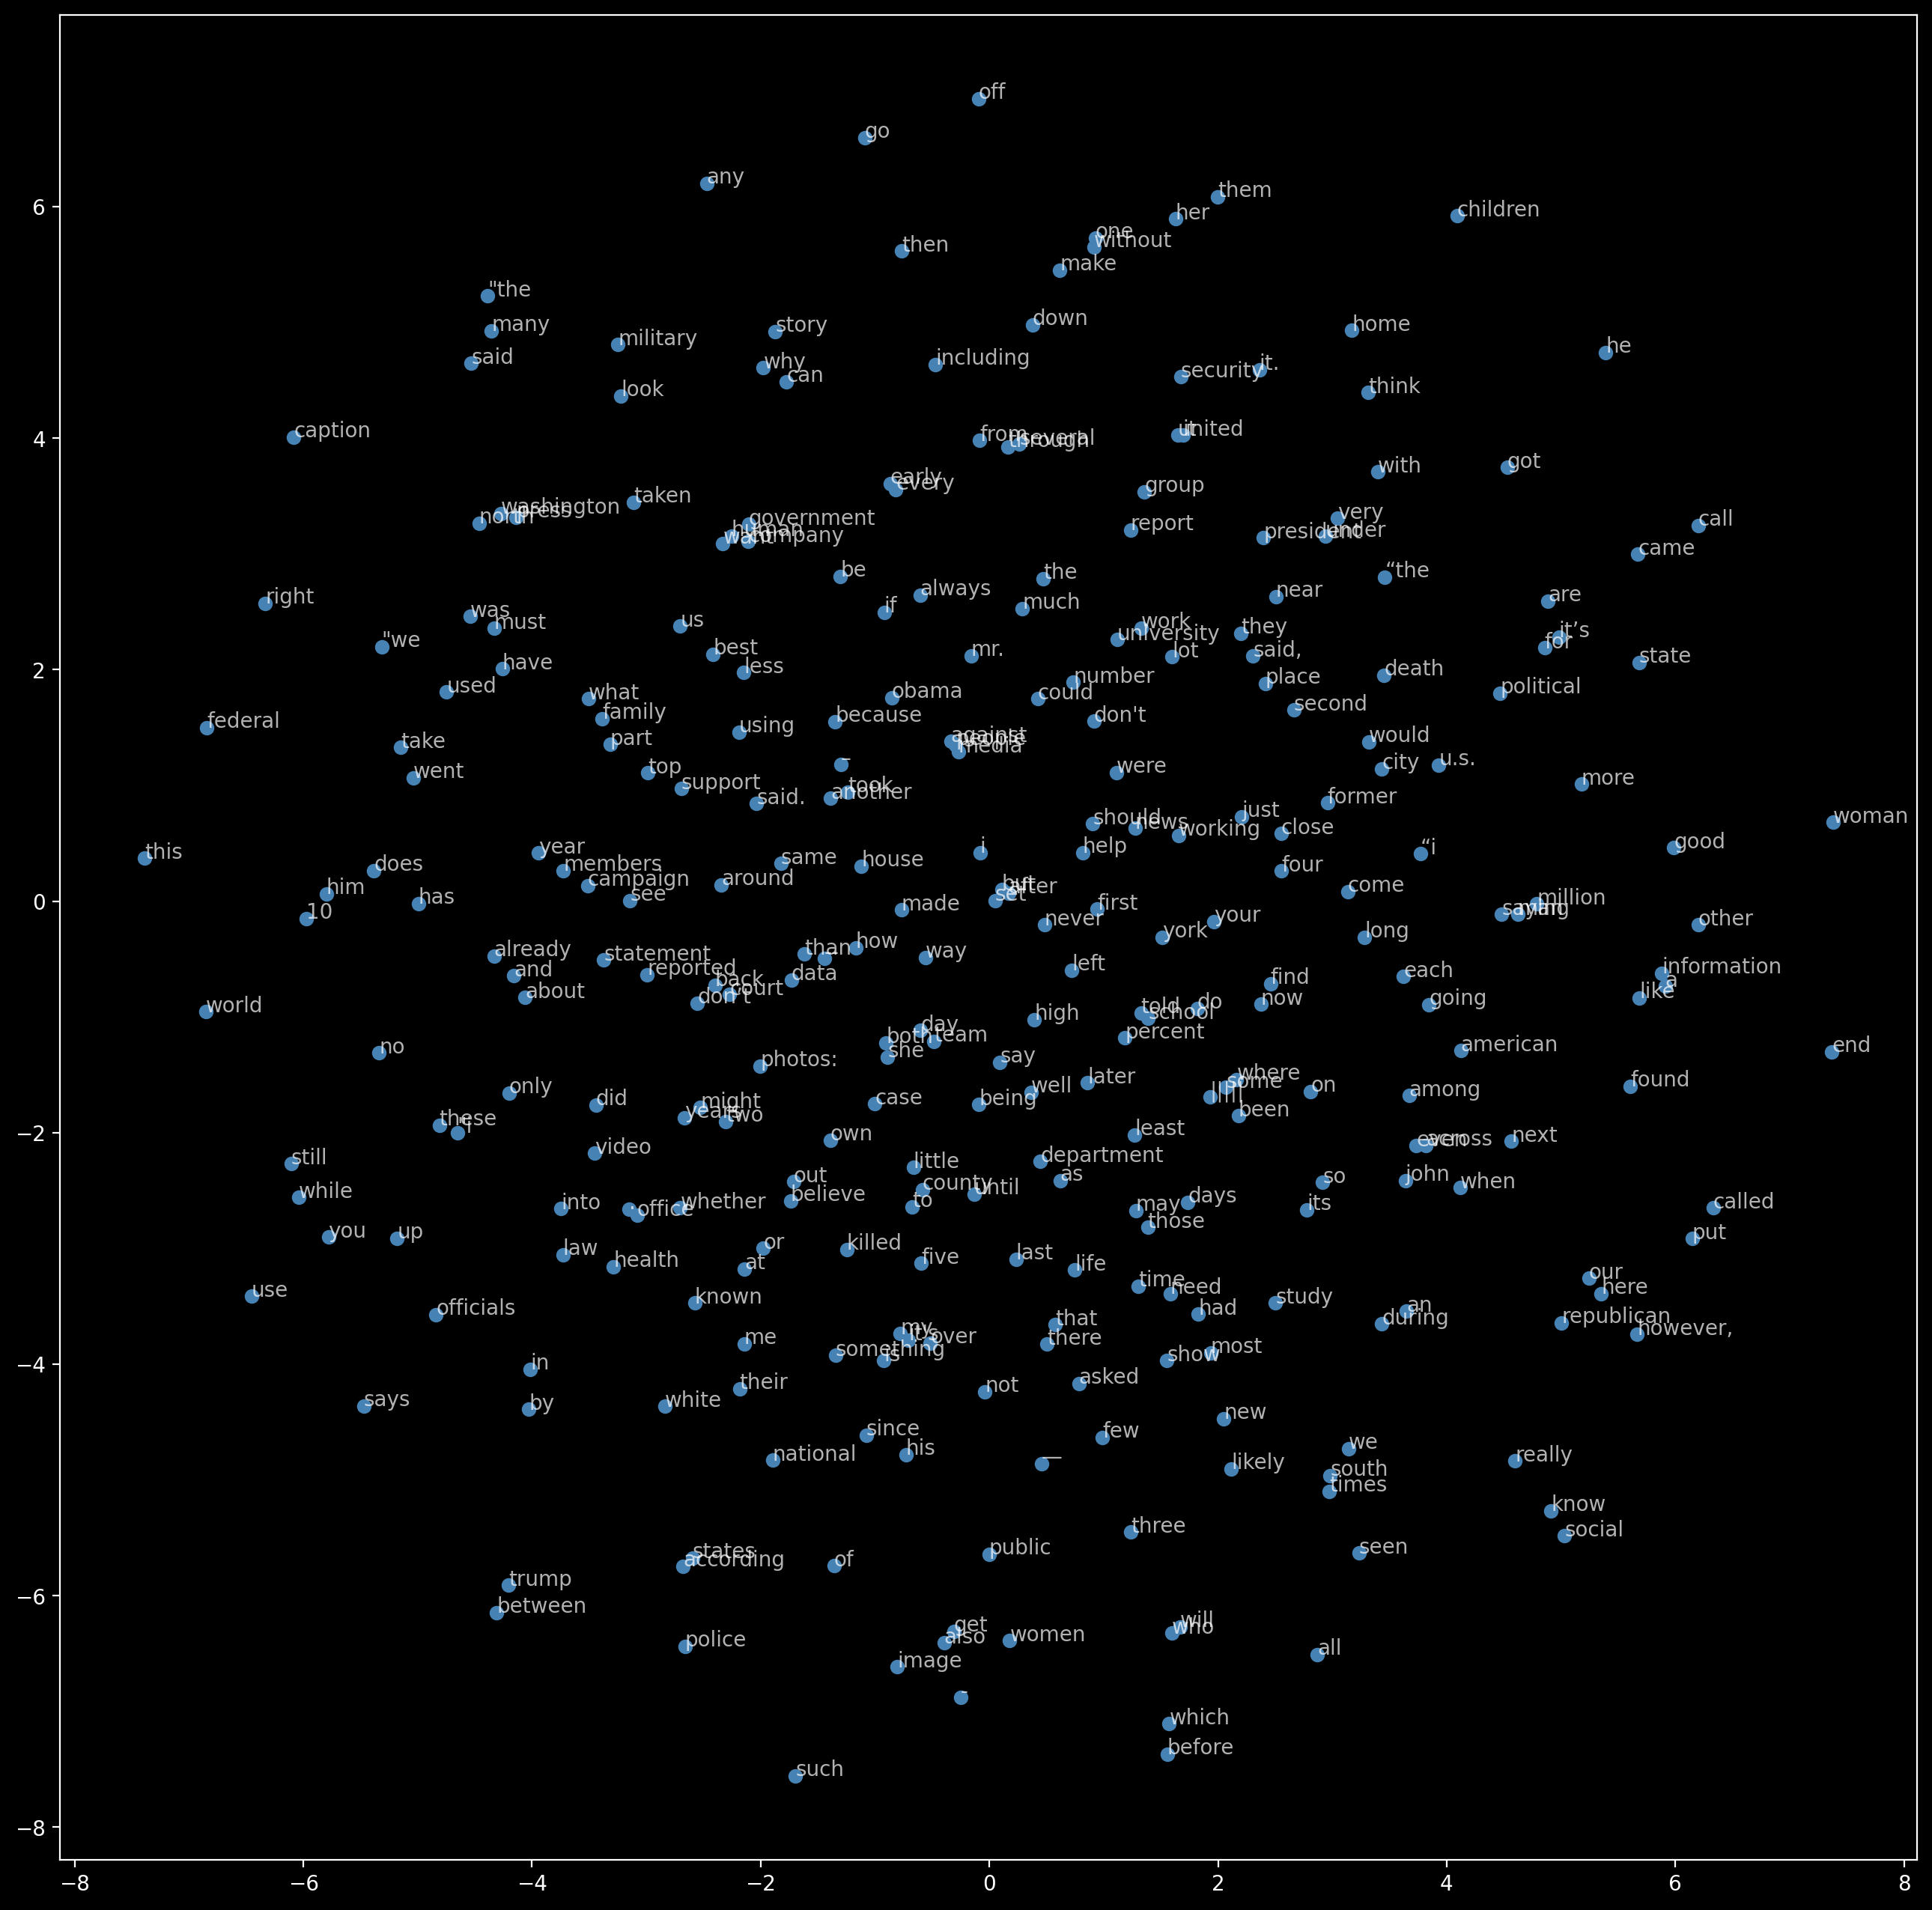

In [19]:
visualize_n_words(300, trained_model)
